#  Spectral unmixing in chemometrics: Workshop

Workshop, December 5th, 2024  
Chungnam  National university  

Software program performs spectral unmixing with;    
 
(a) Multivariate Curve Resolution - Alternating Least Squares (MCR-ALS)  

(b) Multivariate Curve Resolution - Non-negativity Least Squares (MCR-NNLS) 

@ Semyalo Dennis  
LinkedIn: https://www.linkedin.com/in/semyalo-dennis-5471b4158/  
Google scholar: https://scholar.google.com/citations?user=0_jvpccAAAAJ&hl=en  
Email: semyalod@gmail.com

In [2]:
# Import the datetime module for handling date and time operations
import datetime

# Import NumPy, a fundamental package for numerical computations in Python
import numpy as np

# Import the svds function for computing the singular value decomposition of sparse matrices
from scipy.sparse.linalg import svds

# Import Matplotlib's pyplot module for creating static, animated, and interactive visualizations
import matplotlib.pyplot as plt

# Configure Matplotlib to display plots inline within Jupyter notebooks
%matplotlib inline

# Set the resolution of saved figures to 300 dots per inch (DPI) for high-quality images
plt.rcParams['savefig.dpi'] = 300

# Set the default font size for plot text elements to 10 points
plt.rcParams['font.size'] = 10

# Set the default font size for plot legends to 8 points
plt.rcParams['legend.fontsize'] = 8

# Import specific components from the pymcr library for Multivariate Curve Resolution (MCR) analysis

# Import the McrAR class, which implements the Alternating Regression (AR) algorithm for MCR
from pymcr.mcr import McrAR

# Import Ordinary Least Squares (OLS) and Non-Negative Least Squares (NNLS) regressors
from pymcr.regressors import OLS, NNLS

# Import constraints to enforce non-negativity and normalization in the MCR model
from pymcr.constraints import ConstraintNonneg, ConstraintNorm

# Import the mean squared error (MSE) metric for evaluating model performance
from pymcr.metrics import mse

# Import the base Constraint class for defining custom constraints if needed
from pymcr.constraints import Constraint

# Import the default_timer from the timeit module to measure execution time of code snippets
from timeit import default_timer as timer


# Parameters

In [3]:

# -----------------------------------------------------------
# Configuration Settings for Figure Saving and Randomness
# -----------------------------------------------------------

# Flag to determine whether figures generated during the analysis should be saved to disk.
# Setting this to True enables the saving of figures, while setting it to False disables it.
SAVEFIG = True

# Prefix used for naming saved figure files.
# This helps in organizing and identifying figures related to this specific analysis or model.
fig_prefix = 'MCR-AR_Model5'

# Obtain the current date and time.
# This timestamp will be used to uniquely identify saved figures, preventing filename conflicts
# and providing information about when the figures were generated.
now = datetime.datetime.now()

# Format the current date and time into a string to create a standardized prefix for filenames.
# The format '%y%m%d_%H%M' breaks down as follows:
# - %y: Two-digit year (e.g., '24' for 2024)
# - %m: Two-digit month (e.g., '11' for November)
# - %d: Two-digit day of the month (e.g., '16')
# - %H: Two-digit hour in 24-hour format (e.g., '14' for 2 PM)
# - %M: Two-digit minute (e.g., '30')
# This results in a string like '241116_1430', which can be used as a timestamp prefix.
date_prefix = now.strftime('%y%m%d_%H%M')

# Set the seed for NumPy's random number generator.
# This ensures that any random operations performed by NumPy produce the same results each time the script is run,
# which is essential for reproducibility, especially in scientific computations and analyses.
np.random.seed(0)


Matrix shape: (3600, 253)


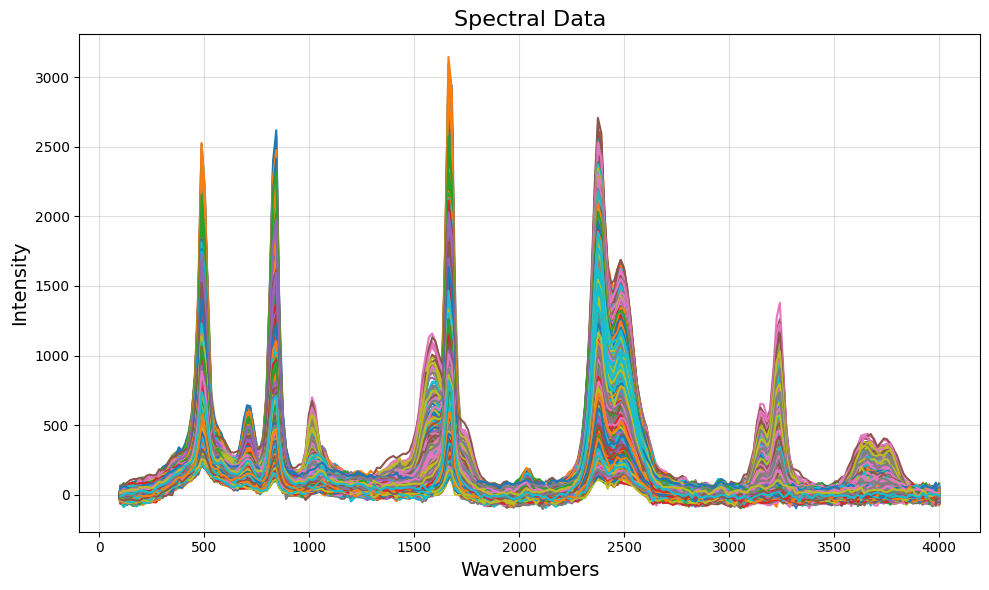

In [5]:
# Oil emulsion dataset
# Data matrix, D: (3600, 253)
# Original size of HSI: (60,60,253)

# Read data matrix
data_matrix = np.loadtxt('emulsion_imageM.csv', delimiter=',')  # For CSV files

print("Matrix shape:", data_matrix.shape)  # Verify the dimensions

# Generate x-axis values (e.g., wavenumbers or wavelength or frequency)
# Replace with actual spectral range if known (or load wavelength file if available)
x_values = np.linspace(100, 4000, data_matrix.shape[1])  # Example: 100-4000 cm-1

# Plot all spectra
plt.figure(figsize=(10, 6))
for spectrum in data_matrix:
    plt.plot(x_values, spectrum)

# Add labels and title
plt.title("Spectral Data", fontsize=16)
plt.xlabel("Wavenumbers", fontsize=14)
plt.ylabel("Intensity", fontsize=14)
plt.grid(alpha=0.4)
plt.tight_layout()

# Show the plot
plt.show()


## Initial spectra estimate

In [6]:
'''
# Generation of initial estimates 
- Purest variable detection/selection method such as SIMPLISMA algorithm.
- manually 
- Evolving Factor Analysis method

SIMPLISMA - Simple-to-use Interactive Self-modeling Mixture Analysis)

'''

# Function to perform SIMPLISMA
def simplisma(D, n_components, small=0.1):
    """
    Perform SIMPLISMA to estimate initial spectra.

    Parameters:
    - D: Data matrix (samples x variables).
    - n_components: Number of pure components to detect.
    - small: Small constant to prevent division by zero.

    Returns:
    - S_estimated: Estimated initial spectra (components x variables).
    - selected_indices: Indices of selected purest variables.
    """
    I, J = D.shape

    # Compute mean and standard deviation for each variable
    m = np.mean(D, axis=0)
    s = np.std(D, axis=0, ddof=1)

    # Compute purity for each variable
    m_max = np.max(m)
    epsilon = small * m_max
    purity = s / (m + epsilon)

    # Initialize variables
    selected_indices = []
    S_estimated = np.zeros((n_components, J))

    for comp in range(n_components):
        # Adjust purity to avoid reselection of variables
        adjusted_purity = purity.copy()
        for idx in selected_indices:
            adjusted_purity[idx] = 0
            # Suppress neighboring variables
            window = 5
            start = max(0, idx - window)
            end = min(J, idx + window + 1)
            adjusted_purity[start:end] = 0

        # Select the variable with the highest adjusted purity
        max_purity_idx = np.argmax(adjusted_purity)
        selected_indices.append(max_purity_idx)

        # Find the sample where the selected variable reaches its maximum
        variable_data = D[:, max_purity_idx]
        max_sample_idx = np.argmax(variable_data)

        # Extract and normalize the spectrum at that sample
        spectrum = D[max_sample_idx, :] / np.max(D[max_sample_idx, :])
        S_estimated[comp, :] = spectrum

    return S_estimated, selected_indices



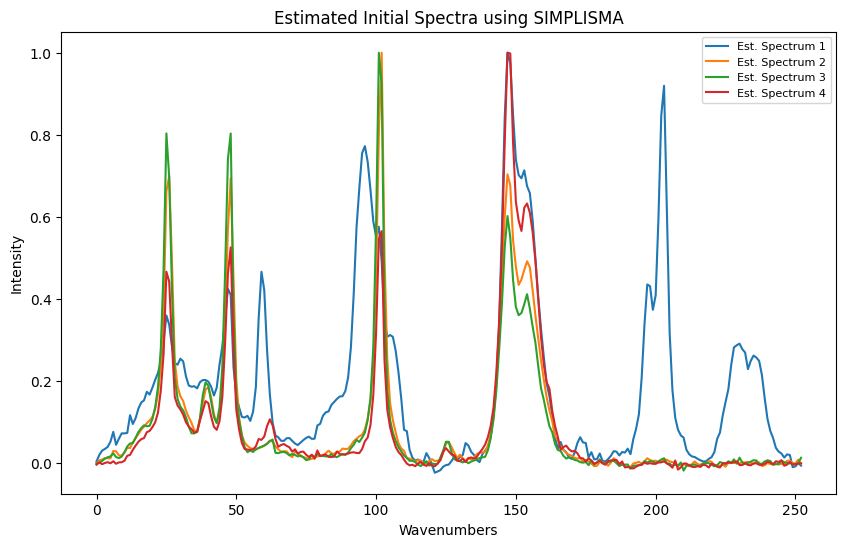

In [7]:
# Generation of initial estimates using SIMPLISMA
# Estimate initial spectra using SIMPLISMA
n_components = 4    # Define the number of spectral components to unmix
initial_spectra, selected_indices = simplisma(data_matrix, n_components) 

# Plot the estimated initial spectra
x = np.arange(data_matrix.shape[1])
plt.figure(figsize=(10, 6))
for i in range(n_components):
    plt.plot(x, initial_spectra[i, :], label=f'Est. Spectrum {i+1}')

plt.xlabel('Wavenumbers')
plt.ylabel('Intensity')
plt.title('Estimated Initial Spectra using SIMPLISMA')
plt.legend()
plt.show()

# Perform spectral unmixing with Multivariate Curve Resolution Alternating Regression(MCR-AR)
1. Multivariate Curve Resolution Alternating Least Squares (MCR-ALS)
2. Multivariate Curve Resolution Alternating Non-Negativity Least Squares (MCR-NNLS)

In [13]:

# Initialize a dictionary to store various comparison metrics for different methods and components
comparison_metrics = {
    'method' : [],            # Name of the unmixing method used (e.g., 'MCR-ALS', 'MCR-NNLS')
    'method_iter' : [],       # Iteration details or identifier for the method's specific run
    'component' : [],         # Identifier or index for the spectral component being analyzed
    'mse' : [],               # Mean Squared Error between the estimated and true spectra or concentrations
}

# Define a list of Multivariate Curve Resolution (MCR) methods to compare
method_list = [
    'MCR-ALS',        # Alternating Least Squares method
    'MCR-NNLS'       # Non-Negative Least Squares method
]

# Define a list of regression methods for spectral (ST) profiles corresponding to each method in method_list
st_regr_list = [
    'OLS',                                 # Ordinary Least Squares regression for spectra
    'NNLS'                                # Non-Negative Least Squares regression for spectra
]

# Define a list of regression methods for concentration (C) profiles corresponding to each method in method_list
c_regr_list = [
    'OLS',                                 # Ordinary Least Squares regression for concentrations
    'NNLS'                                # Non-Negative Least Squares regression for concentrations
    ]

# Define a list of constraints to be applied to concentration (C) profiles for each method in method_list
c_constr_list = [
    [ConstraintNonneg()],                   # Enforce non-negativity constraints on concentrations (MCR-ALS)
    []                                      # No constraints applied to concentrations (MCR-NNLS)
    
]


# Define a list of constraints to be applied to spectral (ST) profiles for each method in method_list
st_constr_list = [
    [ConstraintNonneg(), ConstraintNorm()],  # Enforce non-negativity and normalization constraints on spectra (MCR-ALS)
    [ConstraintNorm()]                      # Enforce normalization constraint on spectra (MCR-NNLS)
]

# Set the number of retests for each method to perform, useful for averaging results over multiple runs
n_retest = 1  # Only one run per method; set higher for multiple evaluations

# Define tolerance parameters for the Alternating Regression (AR) method
ar_tol = {
    'max_iter': 1000,         # Maximum number of iterations allowed for convergence
    #'max_iter': 100,         # Maximum number of iterations allowed for convergence
    'tol_increase': 1e10,     # Tolerance for allowable increase in some convergence metric (context-specific)
    'tol_n_increase': 10000,  # Tolerance related to the number of increases (context-specific)
    'tol_n_above_min': 10000, # Tolerance for iterations above a minimum threshold (context-specific)
    'tol_err_change': 1e-14   # Tolerance for the change in error between iterations to determine convergence
}


In [14]:

# Initialize an empty list to store MCR (Multivariate Curve Resolution) model instances
mcr = []

# Initialize an empty list to specify methods to isolate; if empty, all methods are processed
isolate_method = []

# Enumerate over zipped lists of methods and their corresponding regression and constraint parameters
for num_method, (method, c_regr, st_regr, c_constr, st_const) in enumerate(zip(
        method_list,      # List of MCR methods to be applied
        c_regr_list,      # List of concentration regression parameters for each method
        st_regr_list,     # List of spectral regression parameters for each method
        c_constr_list,    # List of concentration constraints for each method
        st_constr_list)):  # List of spectral constraints for each method
    
    # Create an instance of the McrAR (Alternate Regression) model with specified tolerances and constraints
    mcr.append(McrAR(
        **ar_tol,            # Unpack additional tolerance parameters from ar_tol dictionary
        st_regr=st_regr,     # Spectral regression parameters for the current method
        c_regr=c_regr,       # Concentration regression parameters for the current method
        c_constraints=c_constr,  # Concentration constraints for the current method
        st_constraints=st_const  # Spectral constraints for the current method
    ))
    
    # Access the recently added MCR model instance and set its _saveall_st attribute to True
    # This ensures that all spectral estimates (ST matrices) are saved during fitting
    mcr[num_method]._saveall_st = True
    
    # Check if isolate_method is empty or if the current method index is in isolate_method
    # If isolate_method is empty, all methods are processed; otherwise, only specified methods are processed
    if (len(isolate_method) == 0) or (num_method in isolate_method):
        
        # Perform multiple fitting trials to ensure robustness (n_retest times)
        for num in range(n_retest):
            
            # Print a header indicating the current method being processed
            print('-------- {} --------'.format(method))
            
            # Print the current trial number out of the total number of retests
            print('Trial {} / {}'.format(num + 1, n_retest))
            
            # Start a timer to measure the duration of the fitting process
            tmr = timer()
            
            # Fit the MCR model to the raveled hyperspectral data (data_matrix)
            # ST parameter is initialized with the initial spectra scaled by 1
            # verbose=False suppresses detailed output during fitting
            mcr[num_method].fit(data_matrix, ST=1*initial_spectra, verbose=False)
            #mcr[num_method].fit(data_matrix, ST=1*initial_spectra, verbose=True)
            
            # Stop the timer by subtracting the current time; tmr now holds the elapsed time
            tmr -= timer()
            
            # Print the final Mean Squared Error (MSE) from the fitting process
            # mcr[num_method].err is a list of MSE values for each iteration; [-1] accesses the last value
            print('\nFinal MSE: {:.7e}'.format(mcr[num_method].err[-1]))
                
        # After all trials for the current method, print the Mean Squared Error using known data
        # Calculates the MSE between the raveled hyperspectral data and the estimated data matrix D_opt_
        print('MSE (w known): {:.2e}'.format(
            np.mean((data_matrix - mcr[num_method].D_opt_)**2)
        ))
        
        # Print a separator line for better readability in the output
        print('------------------')


-------- MCR-ALS --------
Trial 1 / 1
Max iterations reached (1000).

Final MSE: 4.9418157e+02
MSE (w known): 4.87e+02
------------------
-------- MCR-NNLS --------
Trial 1 / 1
Max iterations reached (1000).

Final MSE: 4.7252780e+02
MSE (w known): 4.73e+02
------------------


In [15]:
# Check the dimensions of obtained pure spectral profile and disribution map

#print("Pure spectral profile:", mcr[1].ST_opt_[0].shape) #1-> first method in method_list
print("Pure spectral profile 2:", mcr[1].ST_opt_.shape)   #1-> first method in method_list

#print("Distribution map:",  mcr[1].C_opt_[0].shape) #1-> first method in method_list
#print("Distribution map 2:",  mcr[1].C_opt_[..., 0].shape)
print("Distribution map 3:",  mcr[1].C_opt_.shape)      #1-> first method in method_list
     

Pure spectral profile 2: (4, 253)
Distribution map 3: (3600, 4)


# Plot retrieved pure spectra profile and distribution maps

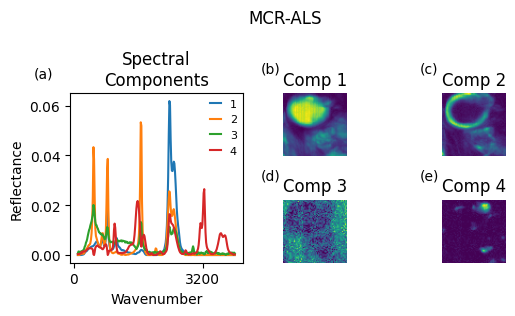

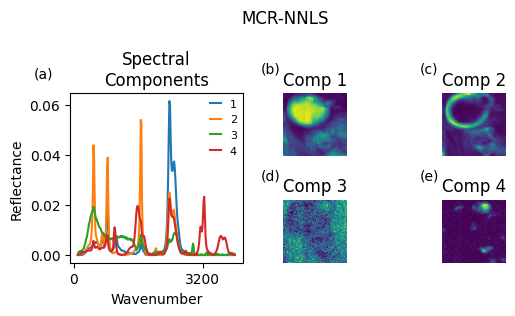

In [16]:
# Original HSI datacube (60,60,253)
# HSI dimensions for visualization of the concentration or distribution maps
HSI_rows = 60;
HSI_cols = 60;
    
# Loop over each method in the method_list using its index (mcr_select)
for mcr_select in range(len(method_list)):
    
    #Rearrange the pure components in ST_opt_ and C_opt_ based on the ones with highest amount in the mixture.
    # ST_opt_: (number of components, number of features)
    # C_opt_: (number of samples, number of components)

    # Calculate the total amount of each component
    total_amounts = np.sum(mcr[mcr_select].C_opt_, axis=0)  # Sum over all samples for each component

    # Get the indices that would sort the components in descending order
    sorted_indices = np.argsort(-total_amounts)  # Negative sign for descending order

    # Step 3: Rearrange the components in ST_opt_ and C_opt_
    C_opt_sorted = mcr[mcr_select].C_opt_[:, sorted_indices]     # Rearranged C_opt_
    ST_opt_sorted = mcr[mcr_select].ST_opt_[sorted_indices, :]   # Rearranged ST_opt_

    # Original components
    #print("Original ST_opt_:", mcr[mcr_select].ST_opt_.shape)
    #print("Original C_opt_:", mcr[mcr_select].C_opt_.shape)

    # Rearranged components
    #print("Rearranged ST_opt_:", ST_opt_sorted.shape)
    #print("Rearranged C_opt_:", C_opt_sorted.shape)
    
    # Create a new figure with a specified size (width=5.5 inches, height=4 inches)
    plt.figure(figsize=(5.5,4))
    
    # Define a subplot within a 4x3 grid, positioned at row 1, column 0, spanning 2 rows
    plt.subplot2grid((4,3), loc=[1,0], rowspan=2)
    
    # Plot the first spectral component (index 0) against the wavenumber
    #plt.plot(x_values, mcr[mcr_select].ST_opt_[0], label='1')
    plt.plot(x_values, ST_opt_sorted[0], label='1')
        
    #print("Pure spectral profile 2:", mcr[mcr_select].ST_opt_.shape)
    
    # Plot the second spectral component (index [1]) against the wavenumber
    #plt.plot(x_values, mcr[mcr_select].ST_opt_[1], label='2')
    plt.plot(x_values, ST_opt_sorted[1], label='2')
    
    # Plot the third spectral component (index [2]) against the wavenumber
    #plt.plot(x_values, mcr[mcr_select].ST_opt_[2], label='3')
    plt.plot(x_values, ST_opt_sorted[2], label='3')
    
    # Plot the fourth spectral component (index [3]) against the wavenumber
    #plt.plot(x_values, mcr[mcr_select].ST_opt_[3], label='4')
    plt.plot(x_values, ST_opt_sorted[3], label='4')
    
    # Label the x-axis
    plt.xlabel('Wavenumber')
    
    # Label the y-axis
    plt.ylabel('Reflectance')
    
    # Add a legend to the plot located at the upper right, without a frame, minimal padding, and short handles
    plt.legend(loc='upper right', frameon=False, borderpad=0, handlelength=1)
    
    # Set the title of the subplot as 'Spectral\nComponents', with a newline between words
    plt.title('Spectral\nComponents')
    
    # (Optional) Set the x-axis limits from 0 to 3000; currently commented out
    # plt.axis(xmin=0, xmax=3000)
    
    # Set the x-ticks to show only at 0 and 3200
    plt.xticks((0, 3200))
    
    # Add text '(a)' at position (-1000, 1.1 * max y-axis value) to label the subplot
    plt.text(-1000, 1.1*plt.axis()[-1], '(a)')
           
    # Define a new subplot in the 4x3 grid at row 1, column 1, spanning 1 row
    plt.subplot2grid((4,3), loc=[1,1], rowspan=1)
    
    # Display an image of the first concentration map, reshaped to match the original concentration shape
    #plt.imshow(mcr[mcr_select].C_opt_[..., 0].reshape(HSI_rows,HSI_cols).T)  
    plt.imshow(C_opt_sorted[..., 0].reshape(HSI_rows,HSI_cols).T)

    #print("Distribution map 3:",  mcr[mcr_select].C_opt_.shape)
    
    # Hide the axis ticks and labels
    plt.axis('off')
    
    # Set the title of the subplot as 'Comp 1'
    plt.title('Comp {}'.format(1))
    
    # Add text '(b)' at position (-22, -20) to label the subplot
    plt.text(-22, -20, '(b)')
        
    # Define another subplot at row 1, column 2, spanning 1 row
    plt.subplot2grid((4,3), loc=[1,2], rowspan=1)
    
    # Display an image of the second concentration map with the same reshaping
    #plt.imshow(mcr[mcr_select].C_opt_[..., 1].reshape(HSI_rows,HSI_cols).T)
    plt.imshow(C_opt_sorted[..., 1].reshape(HSI_rows,HSI_cols).T)
    
    # Hide the axis ticks and labels
    plt.axis('off')
    
    # Set the title of the subplot as 'Comp 2'
    plt.title('Comp {}'.format(2))
    
    # Add text '(c)' at position (-22, -20) to label the subplot
    plt.text(-22, -20, '(c)')
        
    # Define a new subplot at row 2, column 1, spanning 1 row
    plt.subplot2grid((4,3), loc=[2,1], rowspan=1)
    
    # Display an image of the third concentration map with reshaping 
    #plt.imshow(mcr[mcr_select].C_opt_[..., 2].reshape(HSI_rows,HSI_cols).T)
    plt.imshow(C_opt_sorted[..., 2].reshape(HSI_rows,HSI_cols).T)
      
    # Hide the axis ticks and labels
    plt.axis('off')
    
    # Set the title of the subplot as 'Comp 3'
    plt.title('Comp {}'.format(3))
    
    # Add text '(d)' at position (-22, -20) to label the subplot
    plt.text(-22, -20, '(d)')
    
    # Define another subplot at row 2, column 2, spanning 1 row
    plt.subplot2grid((4,3), loc=[2,2], rowspan=1)
    
    # Display an image of the third concentration map with reshaping 
    #plt.imshow(mcr[mcr_select].C_opt_[..., 3].reshape(HSI_rows,HSI_cols).T)
    plt.imshow(C_opt_sorted[..., 3].reshape(HSI_rows,HSI_cols).T)
    
    # Hide the axis ticks and labels
    plt.axis('off')
    
    # Set the title of the subplot as 'Comp 4'
    plt.title('Comp {}'.format(4))
    
    # Add text '(d)' at position (-22, -20) to label the subplot
    plt.text(-22, -20, '(e)')
      
    # Add a super title to the entire figure using the current method's name from method_list
    st = plt.suptitle(method_list[mcr_select])
    
    # Adjust the vertical position of the super title to 90% of the figure height
    st.set_y(0.9)
    
    # Adjust the layout of the figure to prevent overlapping elements
    # 'pad=0' sets padding around the figure
    # 'h_pad=0' and 'w_pad=-1' set horizontal and vertical padding between subplots
    plt.tight_layout(pad=0, h_pad=0, w_pad=-1)
    
    # If the SAVEFIG flag is True, save the figure to a file with a formatted filename
    if SAVEFIG:
        plt.savefig('./{}_{}_{}_Conc_Spectra_Compound.png'.format(date_prefix, fig_prefix, method_list[mcr_select]))
    
    # Display the figure
    plt.show()
    